In [2]:
import glob
import numpy as np
import scipy.stats as st
import torch
import torchvision.transforms as T
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d 
from torch.nn.quantized import functional as qF
from matplotlib.pyplot import imshow
%matplotlib inline

import os



### List of functions:
convolution


## Opening & Converting image to Grayscale

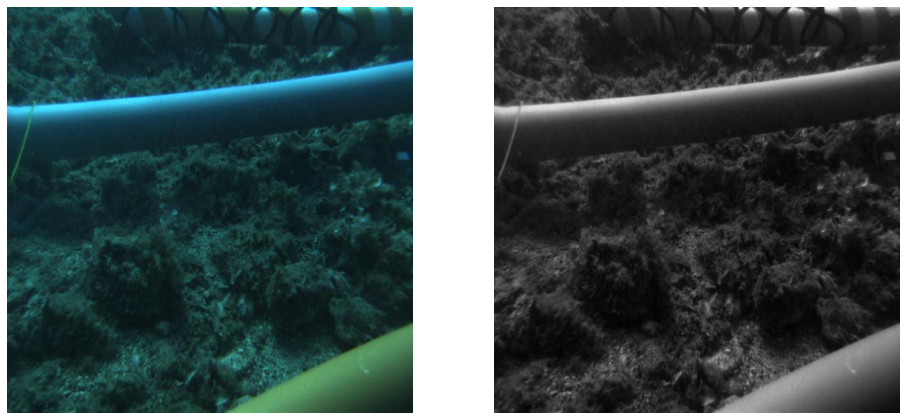

In [3]:
img = Image.open("pipes/train/frame00024_rrgb_jpg.rf.3d8ade0c0424959644be5ee7b6f97ccc.jpg")
img_gray = img.convert("L")   # convert to grayscale
img = np.array(img)
img_gray = np.array(img_gray)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_gray, cmap="gray")

img = img_gray   # use grayscale as final 
img = img/255


In [4]:
def convolution(img,kernel):
    grad = convolve2d(img, kernel, boundary='symm', mode='same')    
    return(np.absolute(grad))


## Blurring Image

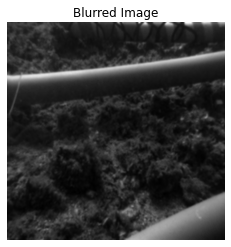

In [5]:
blur_filter = (1/250)*np.ones([5, 5])
blur_filter_tensor=T.ToTensor()(blur_filter)

img_blurred = convolution(img, blur_filter)

plt.axis("off")
plt.title('Blurred Image')
plt.imshow(img_blurred, cmap="gray",)


## Detecting edges

In [6]:
def edge_detection(img):
    """Returns the magnitude and direction of the edges in img"""
    
    sobel_filter_horizontal = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_filter_vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_x = convolution(img, sobel_filter_horizontal)
    img_gradient_y = convolution(img, sobel_filter_vertical)
    img_gradient_magnitude = ((img_gradient_x ** 2) + (img_gradient_y ** 2)) ** (1/2)
    img_gradient_direction = np.arctan2(img_gradient_x, img_gradient_y)
    return img_gradient_x, img_gradient_y, img_gradient_magnitude, img_gradient_direction

### Image Edge Magnitude

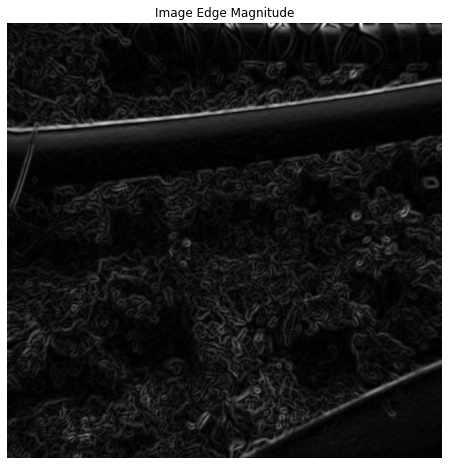

In [7]:
img_gradient_x, img_gradient_y, img_edge_magnitude, img_edge_direction = edge_detection(img_blurred)

plt.figure(figsize=(8,8))
plt.axis("off")

plt.title('Image Edge Magnitude')
plt.imshow(img_edge_magnitude, cmap="gray")


### Image edge magnitude above threshold

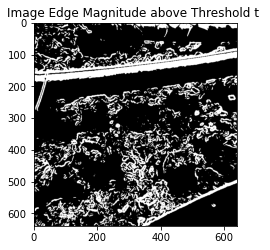

In [8]:
plt.figure(figsize=(8,8))
plt.axis("off")

threshold = 0.01
img_edge_magnitude_thresholded = (img_edge_magnitude > threshold)
plt.subplot(1, 2, 1)
plt.title('Image Edge Magnitude above Threshold t ')
plt.imshow(img_edge_magnitude_thresholded, cmap="gray")


### Image edge direction

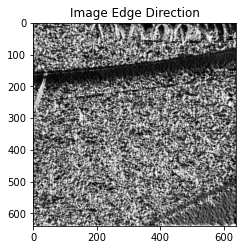

In [9]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.subplot(1, 2, 1)
plt.title('Image Edge Direction')
plt.imshow(img_edge_direction, cmap="gray")

In [33]:
def edgeDetection(img):
#     img_gray = img.convert("L")   # convert to grayscale
#     img = np.array(img)
    img_gray = np.array(img)
#     plt.figure(figsize=(16,8))
#     plt.subplot(1, 2, 1)
#     plt.axis("off")
#     plt.imshow(img)
#     plt.subplot(1, 2, 2)
#     plt.axis("off")
#     plt.imshow(img_gray, cmap="gray")
    img = img_gray   # use grayscale as final 
    img = img/255
    
    
    blur_filter = (1/250)*np.ones([5, 5])
    blur_filter_tensor=T.ToTensor()(blur_filter)
    img_blurred = convolution(img, blur_filter)
#     plt.axis("off")
#     plt.title('Blurred Image')
#     plt.imshow(img_blurred, cmap="gray",)
    
    img_gradient_x, img_gradient_y, img_edge_magnitude, img_edge_direction = edge_detection(img_blurred)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title('Image Edge Magnitude')
    plt.imshow(img_edge_magnitude, cmap="gray")
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    threshold = 0.00005
    img_edge_magnitude_thresholded = (img_edge_magnitude > threshold)
    plt.subplot(1, 2, 1)
    plt.title('Image Edge Magnitude above Threshold t ')
    plt.imshow(img_edge_magnitude_thresholded, cmap="gray")

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.subplot(1, 2, 1)
    plt.title('Image Edge Direction')
    plt.imshow(img_edge_direction, cmap="gray")
    
    return(img_edge_magnitude_thresholded)

                                                                                            

    

    

## Experimental Additions 

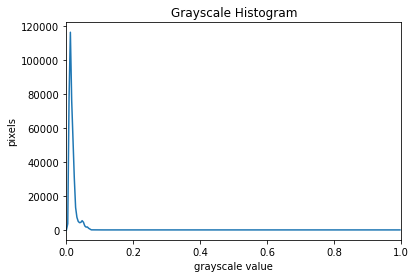

In [11]:
histogram, bin_edges = np.histogram(img_blurred, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

### RAG Thresholding

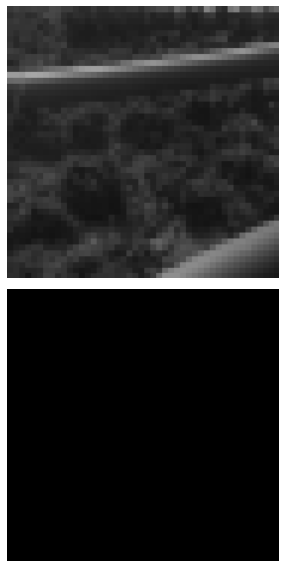

In [12]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


labels1 = segmentation.slic(img, compactness=300, n_segments=2000, start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,
                       figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

### Hysteresis Thresholding

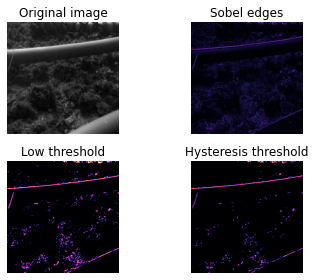

In [13]:
import matplotlib.pyplot as plt
from skimage import data, filters

fig, ax = plt.subplots(nrows=2, ncols=2)

edges = filters.sobel(img)

low = 0.06
high = 0.09

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()


def hysterysis(img):
    edges = filters.sobel(img)

    low = 0.01
    high = 0.9

    lowt = (edges > low).astype(int)
    hight = (edges > high).astype(int)
    hyst = filters.apply_hysteresis_threshold(edges, low, high)
    
    ax[0, 0].imshow(img, cmap='gray')
    ax[0, 0].set_title('Original image')

    ax[0, 1].imshow(edges, cmap='magma')
    ax[0, 1].set_title('Sobel edges')

    ax[1, 0].imshow(lowt, cmap='magma')
    ax[1, 0].set_title('Low threshold')

    ax[1, 1].imshow(hight + hyst, cmap='magma')
    ax[1, 1].set_title('Hysteresis threshold')


    

### Log & Gamma Adjustment

Text(0.5, 1.0, 'Log Adjusted Image')

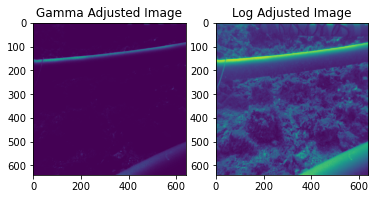

In [14]:
from skimage import exposure

gamma_corrected = exposure.adjust_gamma(img, 4)
log_corrected = exposure.adjust_log(img, 0.2)


plt.subplot(1,2,1)
plt.imshow(gamma_corrected)
plt.title("Gamma Adjusted Image")

plt.subplot(1,2,2)
plt.imshow(log_corrected)
plt.title("Log Adjusted Image")



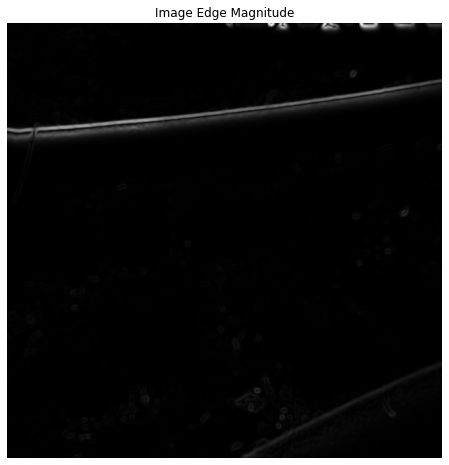

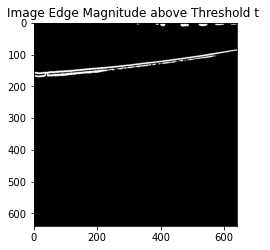

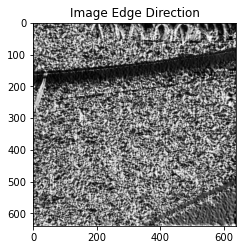

In [24]:
imageinput=edgeDetection(gamma_corrected)


### Gamma Adjustment with Hysteresis Thresholding 

AttributeError: ndim

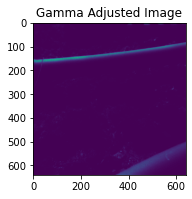

In [17]:
from skimage import exposure
from PIL import Image

gamma_corrected = exposure.adjust_gamma(img, 4)


plt.subplot(1,2,1)
plt.imshow(gamma_corrected)
plt.title("Gamma Adjusted Image")

imageinput=Image.fromarray(gamma_corrected, 'RGB')
imageinput.ndim

hysterysis(imageinput)
edgeDetection(gamma_corrected)


#### Questions:

1. Not sure how gamma and log adjustment work, or what it does
2. What are the proper orders to align all these to obtain the best edge detection (how to construct an image pre processing pipeline)
3. How to select the threshold for Hysterisys Threshold




### Task 3: Hough Transform

<class 'numpy.ndarray'>


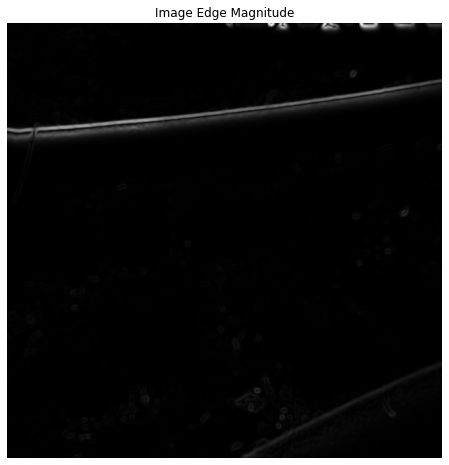

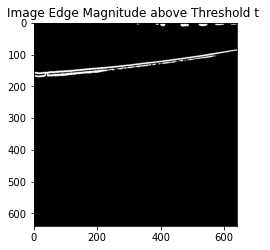

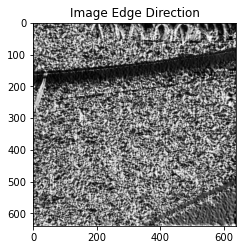

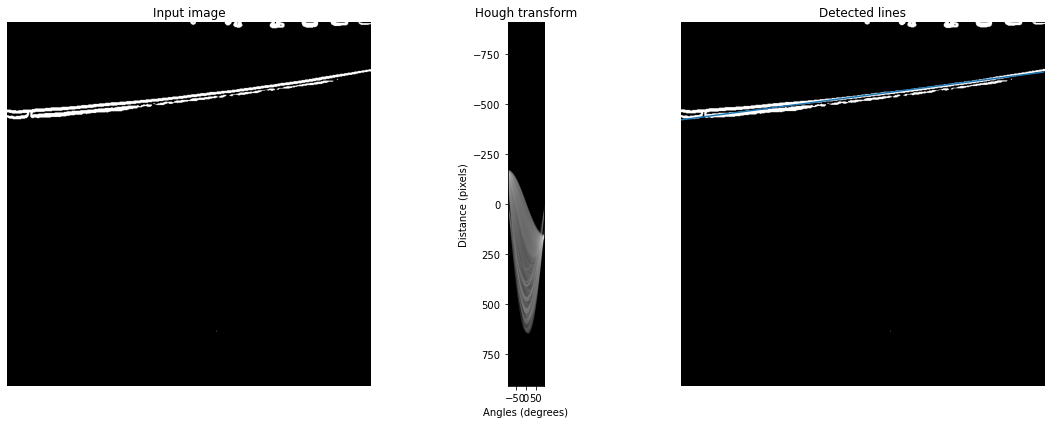

In [34]:

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


imagessssss=edgeDetection(gamma_corrected)
print(type(imagessssss))
imageHough=imagessssss


tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(imageHough, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(imageHough, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(imageHough, cmap=cm.gray)
ax[2].set_ylim((imageHough.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()